In [1]:
!nvidia-smi

Wed Nov  6 02:39:28 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.52.04              Driver Version: 555.52.04      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:20:00.0 Off |                  N/A |
| 30%   29C    P8              3W /  250W |    2173MiB /  11264MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
import random
import yaml
import cv2
import torch  
import torchvision 
from torchvision import transforms, models
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor  
from torchvision.datasets import CocoDetection  
from torchvision.transforms import functional as F  
from torch.utils.data import DataLoader  
from PIL import Image  
import matplotlib.pyplot as plt  
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm 
import numpy as np 
from sklearn.cluster import KMeans


In [3]:
# Set device  
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  

# Load the fine-tuned model weights  
model_load_path = '/home/susmoh-3/r7020_cvip/models/fasterrcnn_model_1.pth'  
state_dict = torch.load(model_load_path, map_location=device, weights_only=True)  

# Initialize the model architecture with pre-trained weights  
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT  
model_t1 = fasterrcnn_resnet50_fpn(weights=weights)  
  
# Replace the head  
num_classes = 2   
in_features = model_t1.roi_heads.box_predictor.cls_score.in_features  
model_t1.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)  
  
# Load the state dictionary from the fine-tuned model  
model_t1.load_state_dict(state_dict)  
  
# Move model to the GPU (when available)  
model_t1.to(device)  

# Set the model to evaluation mode  
model_t1.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


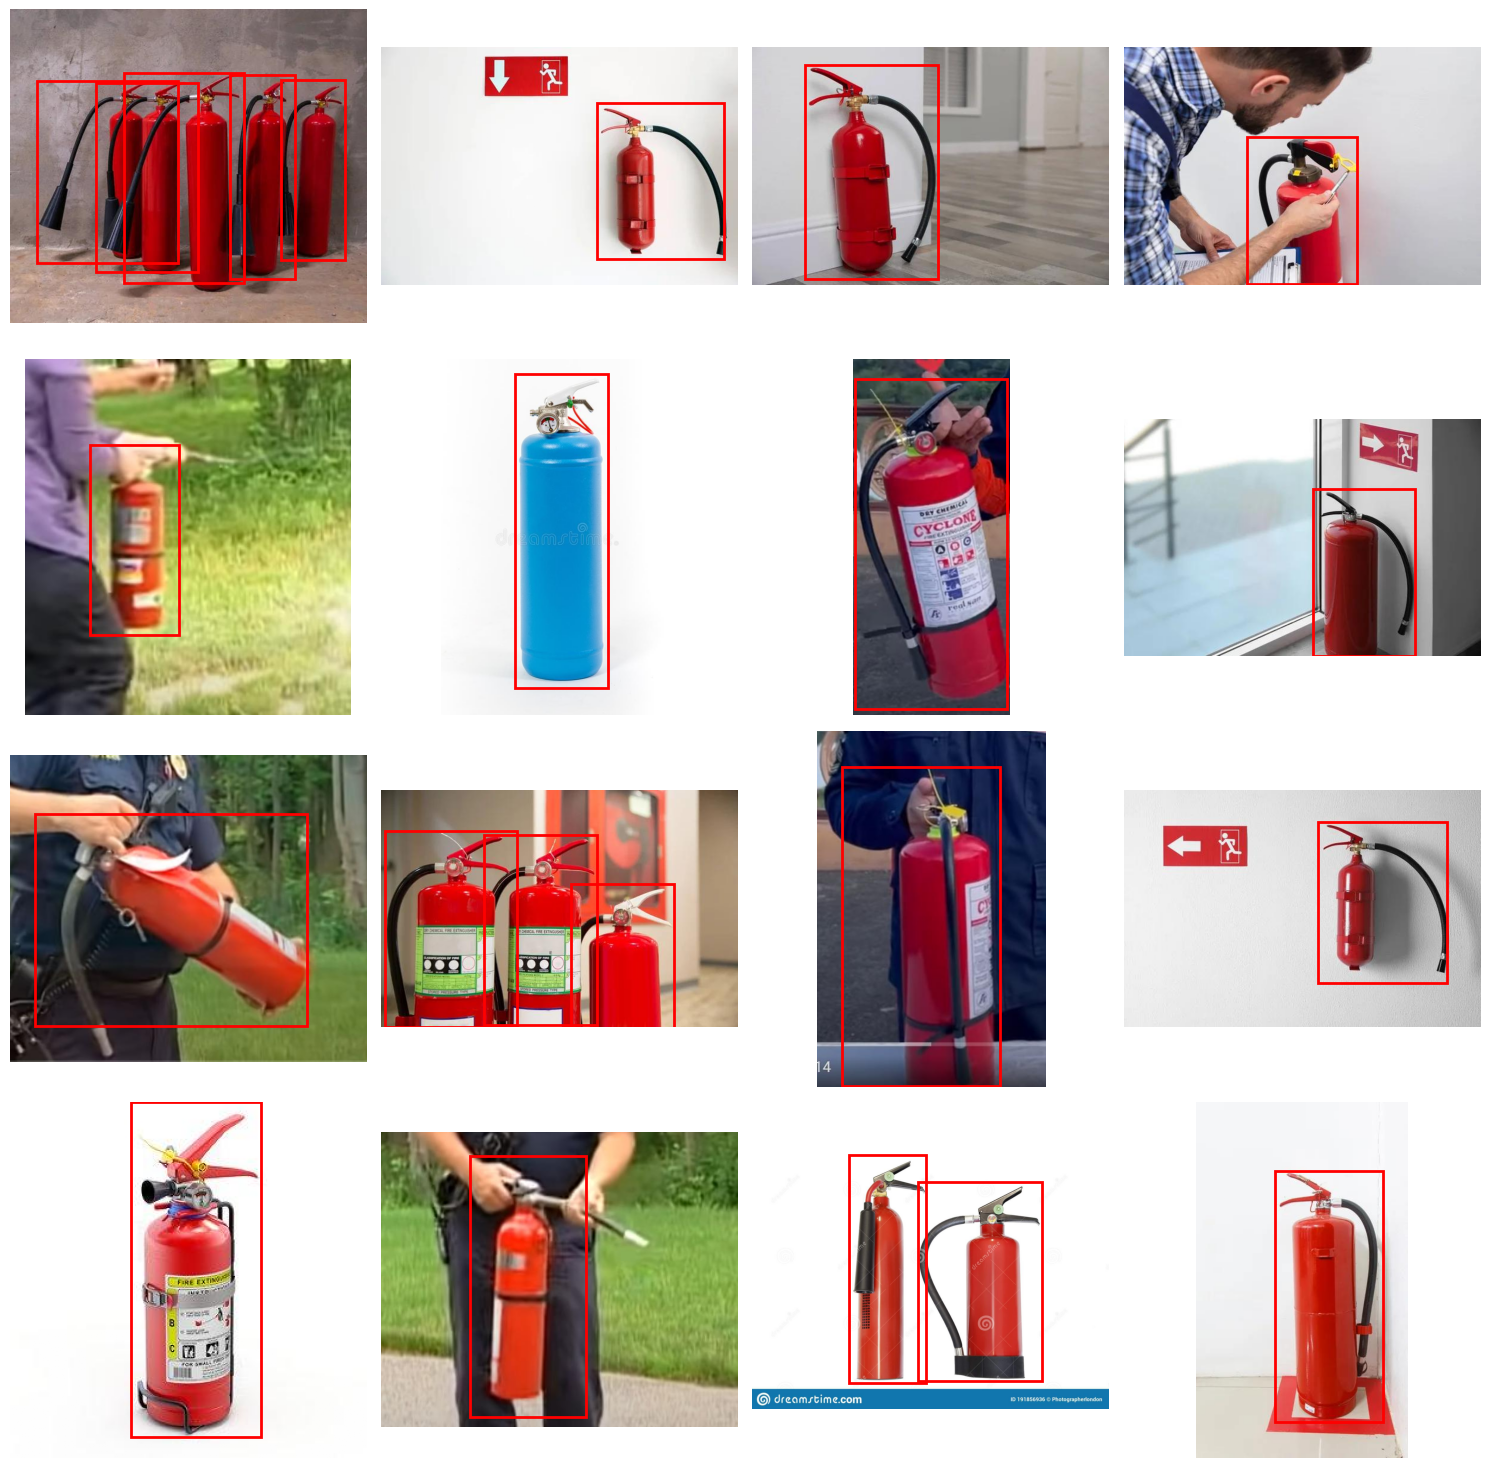

In [4]:
# Function to plot a grid of images with bounding boxes  
def plot_images_with_boxes(images, outputs_list, threshold=0.5):  
    num_images = len(images)  
    grid_size = int(np.ceil(np.sqrt(num_images)))  
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))  
      
    # Ensure axs is always a 2D array  
    if grid_size == 1:  
        axs = np.array([[axs]])  
    elif grid_size == 2:  
        axs = np.array([[axs[0], axs[1]], [axs[2], axs[3]]])  
  
    for idx, (img, outputs) in enumerate(zip(images, outputs_list)):  
        ax = axs[idx // grid_size, idx % grid_size]  
        img = img.permute(1, 2, 0).cpu().numpy()  
        ax.imshow(img)  
          
        for box, score in zip(outputs['boxes'], outputs['scores']):  
            if score > threshold:  
                x1, y1, x2, y2 = box.cpu().detach().numpy()  
                rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2)  
                ax.add_patch(rect)  
          
        ax.axis('off')  
      
    # Hide remaining subplots  
    for idx in range(num_images, grid_size * grid_size):  
        axs[idx // grid_size, idx % grid_size].axis('off')  
  
    plt.tight_layout()  
    plt.show()  
  
def collect_images_and_outputs(val_loader, num_images=16):  
    collected_images = []  
    collected_outputs = []  
      
    with torch.no_grad():  
        for images, _ in val_loader:  
            images = [image.to(device) for image in images]  
            outputs = model_t1(images)  
              
            collected_images.extend(images)  
            collected_outputs.extend(outputs)  
              
            if len(collected_images) >= num_images:  
                break  
      
    return collected_images[:num_images], collected_outputs[:num_images]  

# Custom collate function for handling lists of dictionaries  
def collate_fn(batch):  
    return tuple(zip(*batch)) 

# Define paths  
dataset_dir = '/home/susmoh-3/r7020_cvip/data/fire_extinguiser/coco'  
val_img_dir = f'{dataset_dir}/valid'  
val_ann_file = f'{dataset_dir}/valid/_annotations.coco.json'  

# Load COCO dataset for validation  
val_dataset = CocoDetection(root=val_img_dir, annFile=val_ann_file, transform=F.to_tensor)  
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn) 

# Collect images and their outputs  
images, outputs_list = collect_images_and_outputs(val_loader, num_images=16)  
  
# Plot the images with their bounding boxes  
plot_images_with_boxes(images, outputs_list) 

In [5]:
# Evaluate the fine-tuneed Fast RCNN model on "real and decoy dataset" - functions

# Define transform   
transform = torchvision.transforms.Compose([  
    torchvision.transforms.ToTensor()  
])

def fastrcnn_batched_obj_detection(dir_path, n, model, device, transform):  
    # List all image files in the directory  
    image_files = [f for f in os.listdir(dir_path) if f.endswith(('.png', '.jpg', '.jpeg'))]  
      
    # Select n unique random images  
    selected_images = random.sample(image_files, n)  
      
    # Prepare to collect results  
    collected_images = []  
    collected_outputs = []  
    filenames = []    
      
    # Process each selected image  
    for image_file in selected_images:  
        image_path = os.path.join(dir_path, image_file)  
          
        # Load and preprocess the image  
        image = Image.open(image_path)  
        image = transform(image).unsqueeze(0)  
          
        image = image.to(device)  
          
        # Run inference  
        outputs = model(image)  
          
        # Collect results  
        collected_images.append(image)  
        collected_outputs.append(outputs)  
        filenames.append(image_file)  # Store the original image file name  
      
    return collected_images, collected_outputs, filenames  

def plot_images_with_bboxes(images, outputs, filenames, num_columns=3):  
    num_images = len(images)  
    num_rows = (num_images + num_columns - 1) // num_columns  # Calculate number of rows  
  
    plt.figure(figsize=(15, num_rows * 3))  
  
    for idx, (image, output_list, filename) in enumerate(zip(images, outputs, filenames)):  
        plt.subplot(num_rows, num_columns, idx + 1)  
  
        # Convert the image tensor to a NumPy array for plotting  
        image_np = image.cpu().squeeze(0).permute(1, 2, 0).numpy()  
  
        plt.imshow(image_np)  
  
        # Iterate over the list of outputs for each image  
        for output in output_list:  
            if 'boxes' in output:  
                for box in output['boxes']:  
                    xmin, ymin, xmax, ymax = box.detach().cpu().numpy()  
                    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,  
                                         fill=False, color='red', linewidth=2)  
                    plt.gca().add_patch(rect)  
          
        plt.title(filename)
  
    plt.tight_layout()  
    plt.show()   

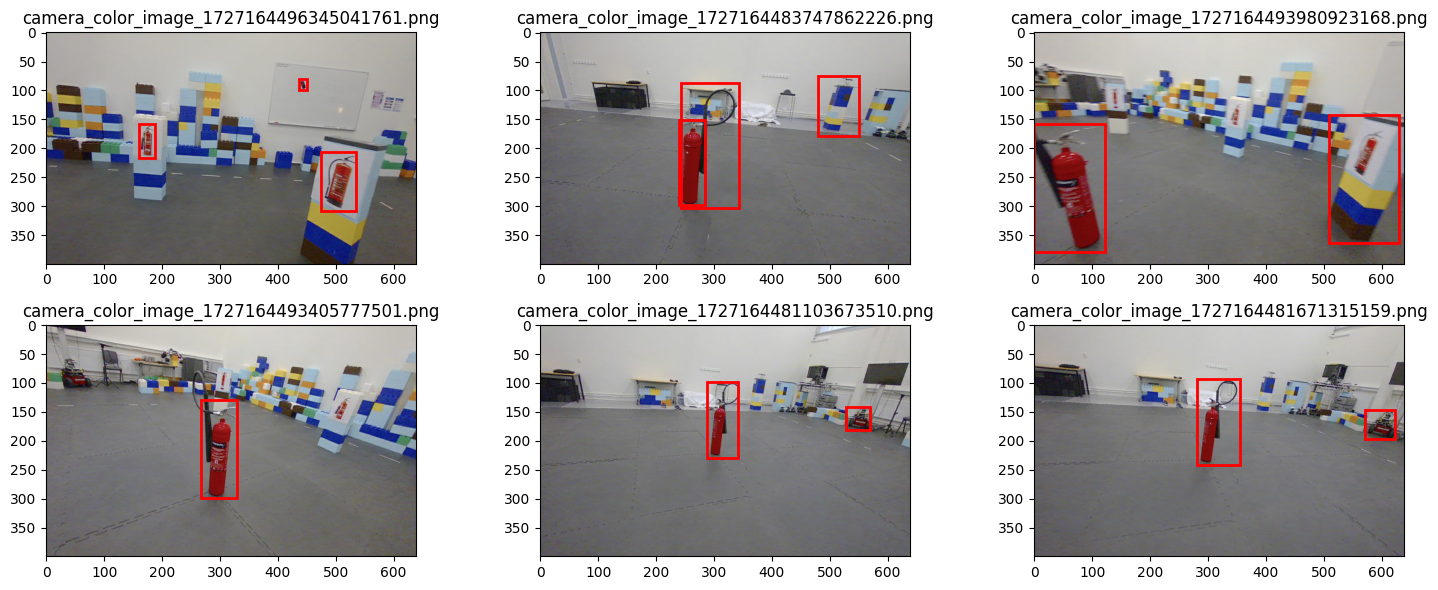

In [6]:
# Evaluate the fine-tuneed Fast RCNN model on "real and decoy dataset"
rd_images_dir = '/home/susmoh-3/r7020_cvip/data/real_and_decoy/raw/test/camera_color_image_raw'
collected_images, collected_outputs, filenames = fastrcnn_batched_obj_detection(rd_images_dir, 6, model_t1, device, transform)
plot_images_with_bboxes(collected_images, collected_outputs, filenames, 3)
torch.cuda.empty_cache()  

In [7]:
# Filter decoy objects, Steps
# Extract feature from bounding box regions with a pretrained resnet18
# apply KMEAN to cluster bbox images into two groups (real and decy)
# Filter bbox for 1 of the cluster(real) to only sow real fire-extinguisher


# Load pre-trained model for feature extraction  
model_resnet18 = torchvision.models.resnet18(pretrained=True)  
model_resnet18 = torch.nn.Sequential(*list(model_resnet18.children())[:-1])  # Remove last layer  
model_resnet18.eval()  
  
# Define transformation  
transform_2 = transforms.Compose([  
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])  
  
def extract_features(image):  
    with torch.no_grad():  
        image = transform(image).unsqueeze(0)  
        features = model_resnet18(image)  
    return features.flatten().numpy()  
  
 
features = []  
for img, output in zip(collected_images, collected_outputs):   
    for box in output[0]['boxes']:   
        box = box.detach().cpu().numpy()  
        cropped_img = img.cpu().squeeze(0).permute(1, 2, 0).numpy()  # Convert tensor to NumPy array  
        cropped_img = Image.fromarray((cropped_img * 255).astype('uint8'))  # Convert to PIL image  
        cropped_img = cropped_img.crop((box[0], box[1], box[2], box[3]))  # Crop using box coordinates  
        features.append(extract_features(cropped_img))   
  
# Apply clustering  
kmeans = KMeans(n_clusters=2, random_state=0).fit(features)  
  
# Update the filtering logic to filter boxes per image  
filtered_boxes_per_image = []  
start_idx = 0  
  
for output in collected_outputs:  
    num_boxes = len(output[0]['boxes'])  
    # Filter boxes for each image  
    filtered_boxes = [box for i, box in enumerate(output[0]['boxes']) if kmeans.labels_[start_idx + i] == 1]  
    filtered_boxes_per_image.append(filtered_boxes)  
    start_idx += num_boxes 

/home/susmoh-3/r7020_cvip/venv_cvip/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/susmoh-3/r7020_cvip/venv_cvip/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


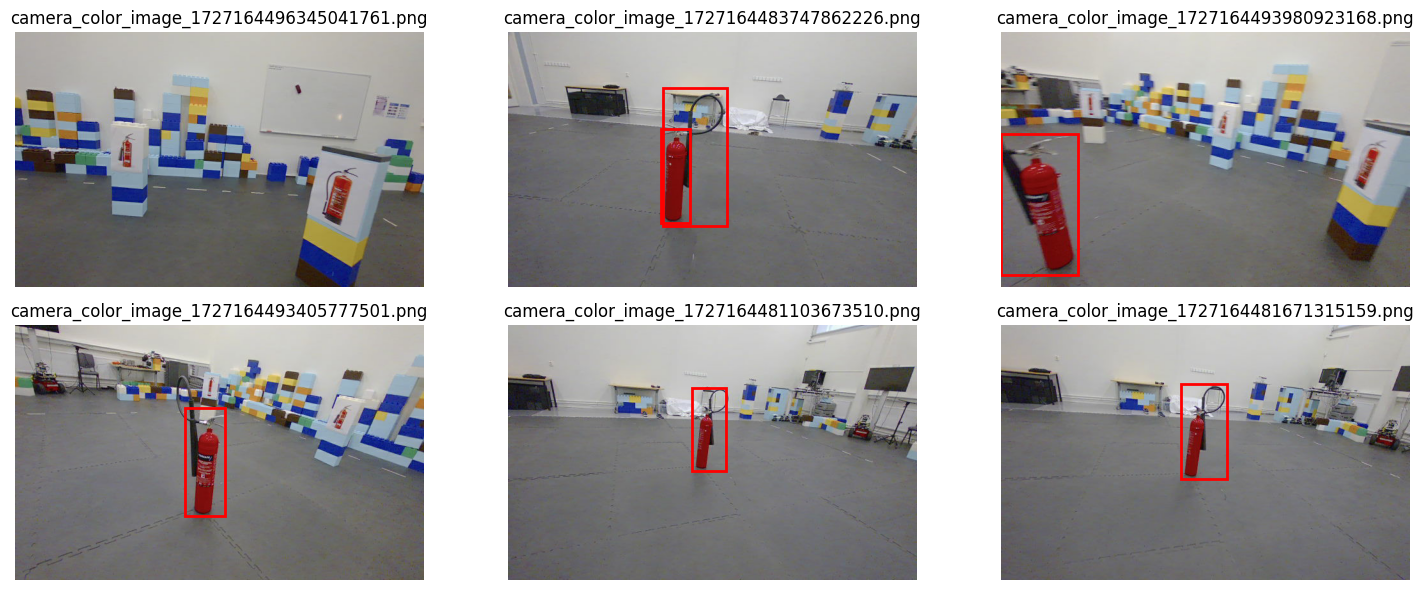

In [8]:
def plot_images_with_filtered_bboxes(images, filtered_boxes_per_image, filenames, num_columns=3):  
    num_images = len(images)  
    num_rows = (num_images + num_columns - 1) // num_columns  # Calculate number of rows  
  
    plt.figure(figsize=(15, num_rows * 3))  
  
    for idx, (image, boxes, filename) in enumerate(zip(images, filtered_boxes_per_image, filenames)):  
        plt.subplot(num_rows, num_columns, idx + 1)  
  
        # Convert the image tensor to a NumPy array for plotting  
        image_np = image.cpu().squeeze(0).permute(1, 2, 0).numpy()  
        plt.imshow(image_np)  
  
        # Draw each filtered box  
        for box in boxes:  
            box = box.detach().cpu().numpy()  # Ensure the box is a NumPy array  
            xmin, ymin, xmax, ymax = box  
            # Draw the bounding box  
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,  
                                 fill=False, color='red', linewidth=2)  
            plt.gca().add_patch(rect)  
          
        plt.title(filename)  # Use the filename as the title of the subplot  
        plt.axis('off')  
  
    plt.tight_layout()  
    plt.show()  
  
# Call the function with your filtered boxes per image  
plot_images_with_filtered_bboxes(collected_images, filtered_boxes_per_image, filenames) 

In [9]:
# Approximate 3D position of real objects

# Function to Calculate 3D coordinates (From Jose)
def get_3d_position(depth_image: np.ndarray, x: np.ndarray, y: np.ndarray, K: np.ndarray) -> np.ndarray:
    """Get 3D position of object.

    Args:
        depth_image (numpy.ndarray): Depth image.
        x (np.ndarray): x-coordinate of object.
        y (np.ndarray): y-coordinate of object.
        K (np.ndarray): Camera intrinsic matrix.

    Returns:
        position: 3D position of object
    """
    depth = depth_image[y, x]
    fx, fy, cx, cy = K[0, 0], K[1, 1], K[0, 2], K[1, 2]
    X = (x - cx) * depth / fx
    Y = (y - cy) * depth / fy
    Z = depth
    return np.array([X, Y, Z])

# Function to find most probable depth image for the color image
def get_depth_image(color_image_name, depth_images_dir):
    """Get Name of the depth image in close timeframe.  
  
    Args:  
        color_image_name: Color image name. 
        depth_images_dir: path of the depth images directory
  
    Returns:  
        closest_depth_image: Name of the depth image.  
    """  
    # Extract timestamp from the color image filename  
    color_timestamp = int(color_image_name.rsplit('_', 1)[1].split('.')[0]) 
  
    # List all depth images    
    depth_images = [  
        f for f in os.listdir(depth_images_dir)  
        if os.path.isfile(os.path.join(depth_images_dir, f))  
    ]
  
    # Initialize variables to track the closest image  
    closest_depth_image = None  
    min_time_diff = float('inf')  
  
    # Find the depth image with the closest timestamp  
    for depth_image in depth_images:  
        # Extract timestamp from the depth image filename  
        depth_timestamp = int(depth_image.rsplit('_', 1)[1].split('.')[0])
          
        # Calculate time difference  
        time_diff = abs(color_timestamp - depth_timestamp)  
          
        # Update the closest image if a closer one is found  
        if time_diff < min_time_diff:  
            min_time_diff = time_diff  
            closest_depth_image = depth_image  
  
    return closest_depth_image  

color_images_dir = '/home/susmoh-3/r7020_cvip/data/real_and_decoy/raw/test/camera_color_image_raw'
depth_images_dir = '/home/susmoh-3/r7020_cvip/data/real_and_decoy/raw/test/camera_depth_image_raw'

#Pick any random info file for camera parameter as they remain same 
color_camera_info_file = '/home/susmoh-3/r7020_cvip/data/real_and_decoy/raw/test/camera_color_camera_info/camera_color_info_1727164479160357265.txt'


#import camera parameters from yaml
with open(color_camera_info_file) as file:
        camera_params = yaml.safe_load(file)
K = np.array(camera_params["K"]).reshape(3, 3)

pos_3d_per_image = []
# Loop over all the selected test images and calculate the 3d position
for boxes, filename in zip(filtered_boxes_per_image, filenames):
    depth_img_name = get_depth_image(filename, depth_images_dir)
    
    clr_image_path = os.path.join(color_images_dir, filename)
    depth_image_path = os.path.join(depth_images_dir, depth_img_name)

    color_image = cv2.imread(clr_image_path, cv2.IMREAD_COLOR)
    depth_image = cv2.imread(depth_image_path, cv2.IMREAD_UNCHANGED)
    pos_3d_boxes = []
    for box in boxes:  
        box = box.detach().cpu().numpy()
        xmin, ymin, xmax, ymax = box
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        pos_3d = get_3d_position(depth_image=depth_image, K=K, x=(xmin + xmax) // 2, y=(ymin + ymax) // 2)
        pos_3d_boxes.append(pos_3d)
    pos_3d_per_image.append(pos_3d_boxes)

print(pos_3d_per_image)

[[], [array([-265.21266267,  104.38742324, 1412.        ]), array([-0., -0.,  0.])], [array([-1305.04587357,   336.29528664,  1545.        ])], [array([ -90.66674722,   55.90868758, 1355.        ])], [array([ -26.60996023, -293.6821174 , 2343.        ])], [array([ -10.8285833 , -259.51217558, 2246.        ])]]


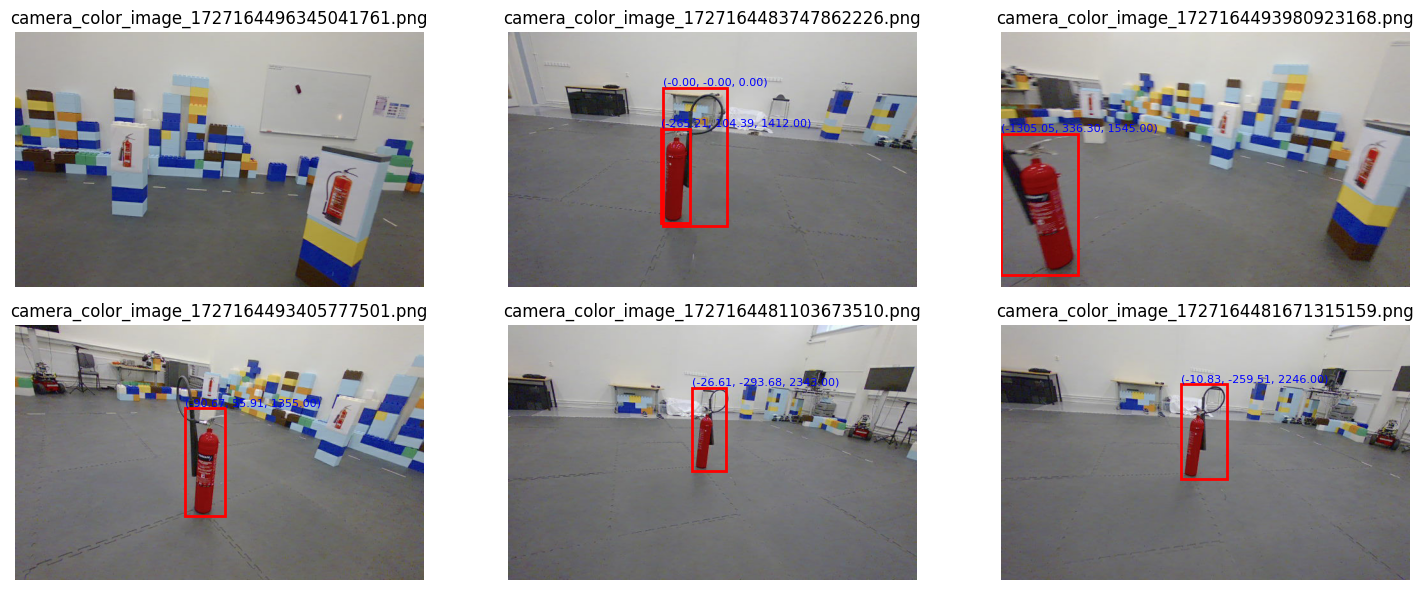

In [10]:
def plot_images_with_filtered_bboxes_and_3d_positions(images, filtered_boxes_per_image, filenames, pos_3d_per_image, num_columns=3):  
    num_images = len(images)  
    num_rows = (num_images + num_columns - 1) // num_columns  # Calculate number of rows  
    plt.figure(figsize=(15, num_rows * 3))  
      
    for idx, (image, boxes, filename, pos_3d_boxes) in enumerate(zip(images, filtered_boxes_per_image, filenames, pos_3d_per_image)):  
        plt.subplot(num_rows, num_columns, idx + 1)  
          
        # Convert the image tensor to a NumPy array for plotting  
        image_np = image.cpu().squeeze(0).permute(1, 2, 0).numpy()  
        plt.imshow(image_np)  
          
        # Draw each filtered box and add 3D position  
        for box, pos_3d in zip(boxes, pos_3d_boxes):  
            box = box.detach().cpu().numpy()  # Ensure the box is a NumPy array  
            xmin, ymin, xmax, ymax = box  
              
            # Draw the bounding box  
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,  
                                 fill=False, color='red', linewidth=2)  
            plt.gca().add_patch(rect)  
              
            # Add 3D position text  
            pos_3d_text = f"({pos_3d[0]:.2f}, {pos_3d[1]:.2f}, {pos_3d[2]:.2f})"  
            plt.text(xmin, ymin, pos_3d_text, fontsize=8, color='blue',   
                     verticalalignment='bottom', horizontalalignment='left')  
          
        plt.title(filename)  # Use the filename as the title of the subplot  
        plt.axis('off')  
      
    plt.tight_layout()  
    plt.show()  
  
 
plot_images_with_filtered_bboxes_and_3d_positions(collected_images, filtered_boxes_per_image, filenames, pos_3d_per_image)  